**Pregunta 18**

In relation to the book of Gujarati (basic econometrics), answer question 22.11 pp 799: Consider the data on log DPI (personal disposable income) introduced in Section 21.1
(see the book’s website for the current data). Suppose you want to fit a suitable ARIMA
model to these data. Outline the steps involved in carrying out this task

In [1]:
# --------------------------------------------------------------
# 1. Upload the Excel file (run only if re-uploading)
# --------------------------------------------------------------
from google.colab import files
uploaded = files.upload()

# --------------------------------------------------------------
# 2. Get the uploaded file name
# --------------------------------------------------------------
import pandas as pd
import io

file_name = list(uploaded.keys())[0]
print(f"Uploaded file: **{file_name}**")

# --------------------------------------------------------------
# 3. Read the Excel file
# --------------------------------------------------------------
df = pd.read_excel(io.BytesIO(uploaded[file_name]))

# --------------------------------------------------------------
# 4. Extract and display only 'YEAR' and 'LOG PDI' columns
# --------------------------------------------------------------
try:
    # Select only the two desired columns
    df_selected = df[['YEAR', 'LOG PDI']]
    print("\n=== Selected Columns: YEAR & LOG PDI ===")
    print(df_selected)

    # Optional: Save or use df_selected for further analysis
    # df_selected.to_csv('year_logpdi_data.csv', index=False)

except KeyError as e:
    print("\nWarning: One or both columns not found:", e)
    print("\nAvailable columns in the file:")
    print(df.columns.tolist())
    print("\nTip: Check spelling, case sensitivity, or extra spaces in column names.")

Saving Table_21_1-2.xlsx to Table_21_1-2.xlsx
Uploaded file: **Table_21_1-2.xlsx**

=== Selected Columns: YEAR & LOG PDI ===
      YEAR   LOG PDI
0   1970.1  3.298984
1   1970.2  3.305373
2   1970.3  3.310757
3   1970.4  3.310736
4   1971.1  3.316788
..     ...       ...
83  1990.4  3.547713
84  1991.1  3.545901
85  1991.2  3.548684
86  1991.3  3.548991
87  1991.4  3.549922

[88 rows x 2 columns]


In [3]:

# --------------------------------------------------------------
# 2. Read the file and keep only YEAR & LOG PDI
# --------------------------------------------------------------
import pandas as pd
import io
from statsmodels.tsa.stattools import adfuller
import numpy as np

file_name = list(uploaded.keys())[0]
print(f"Uploaded file: **{file_name}**\n")

df = pd.read_excel(io.BytesIO(uploaded[file_name]))

# ---- Clean column names (remove leading/trailing blanks) ----
df.columns = df.columns.str.strip()

required_cols = ['YEAR', 'LOG PDI']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Columns not found: {missing}\n"
                   f"Available columns: {df.columns.tolist()}")

data = df[required_cols].copy()
data = data.dropna()                     # drop rows with NaN
data = data.set_index('YEAR')            # YEAR → index (optional but handy)

series = data['LOG PDI']

# --------------------------------------------------------------
# 3. ADF test function (returns a nice dictionary)
# --------------------------------------------------------------
def adf_test(y, title=''):
    """Run ADF test and return results as dict."""
    result = adfuller(y, autolag='AIC')
    out = {
        'Test Statistic': result[0],
        'p-value': result[1],
        '#Lags Used': result[2],
        '#Obs Used': result[3],
        'Critical 1%': result[4]['1%'],
        'Critical 5%': result[4]['5%'],
        'Critical 10%': result[4]['10%']
    }
    print(f"\n=== ADF Test: {title} ===")
    for k, v in out.items():
        print(f"{k:>15}: {v:.6f}")
    return out

# --------------------------------------------------------------
# 4. Run ADF on LEVEL and FIRST DIFFERENCE
# --------------------------------------------------------------
level_res   = adf_test(series,               title='LEVEL (LOG PDI)')
diff1       = series.diff().dropna()
diff1_res   = adf_test(diff1,                title='FIRST DIFFERENCE (ΔLOG PDI)')

# --------------------------------------------------------------
# 5. Summary table
# --------------------------------------------------------------
summary = pd.DataFrame({
    'Level': level_res,
    'First Diff': diff1_res
}).T
summary = summary[['Test Statistic','p-value','#Lags Used','#Obs Used',
                   'Critical 1%','Critical 5%','Critical 10%']]

print("\n=== SUMMARY TABLE ===")
print(summary.round(6))

# --------------------------------------------------------------
# 6. Automatic interpretation (5% significance)
# --------------------------------------------------------------
def interpret(p):
    return "Stationary (reject H0)" if p < 0.05 else "Non-stationary (fail to reject H0)"

print("\n=== INTERPRETATION (α = 0.05) ===")
print(f"Level series      : {interpret(level_res['p-value'])} (p = {level_res['p-value']:.6f})")
print(f"First difference  : {interpret(diff1_res['p-value'])} (p = {diff1_res['p-value']:.6f})")

Uploaded file: **Table_21_1-2.xlsx**


=== ADF Test: LEVEL (LOG PDI) ===
 Test Statistic: -1.440747
        p-value: 0.562593
     #Lags Used: 5.000000
      #Obs Used: 82.000000
    Critical 1%: -3.512738
    Critical 5%: -2.897490
   Critical 10%: -2.585949

=== ADF Test: FIRST DIFFERENCE (ΔLOG PDI) ===
 Test Statistic: -4.669160
        p-value: 0.000096
     #Lags Used: 4.000000
      #Obs Used: 82.000000
    Critical 1%: -3.512738
    Critical 5%: -2.897490
   Critical 10%: -2.585949

=== SUMMARY TABLE ===
            Test Statistic   p-value  #Lags Used  #Obs Used  Critical 1%  \
Level            -1.440747  0.562593         5.0       82.0    -3.512738   
First Diff       -4.669160  0.000096         4.0       82.0    -3.512738   

            Critical 5%  Critical 10%  
Level          -2.89749     -2.585949  
First Diff     -2.89749     -2.585949  

=== INTERPRETATION (α = 0.05) ===
Level series      : Non-stationary (fail to reject H0) (p = 0.562593)
First difference  : Stationar

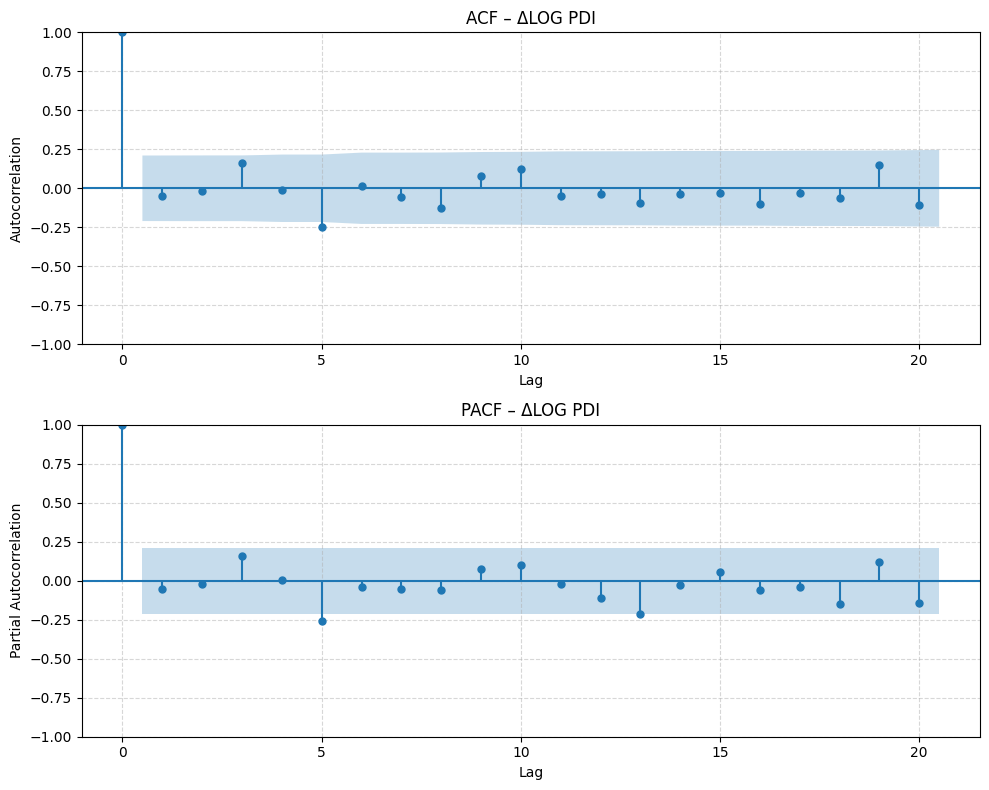


=== INTERPRETATION TIP ===
• Significant spike at lag 1 in PACF → possible AR(1) term
• Significant spikes at first few lags in ACF  → possible MA terms
• If both decay quickly → white noise (already stationary)
• Use the number of significant lags to choose p (AR) and q (MA) in ARIMA(p,1,q)


In [4]:
# --------------------------------------------------------------
# 1. Make sure the first difference is available
# --------------------------------------------------------------
# If you ran the previous ADF code, `diff1` already exists.
# If not, recreate it quickly:
# diff1 = series.diff().dropna()

# --------------------------------------------------------------
# 2. Plot ACF and PACF of the first difference
# --------------------------------------------------------------
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# ---- ACF ----
plot_acf(diff1, lags=20, ax=ax1, alpha=0.05, title='ACF – ΔLOG PDI')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Autocorrelation')
ax1.grid(True, linestyle='--', alpha=0.5)

# ---- PACF ----
plot_pacf(diff1, lags=20, ax=ax2, alpha=0.05, title='PACF – ΔLOG PDI', method='ywm')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Partial Autocorrelation')
ax2.grid(True, linestyle='--', alpha=0.5)

# Adjust layout and show
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# 3. Quick interpretation guide (printed below the plot)
# --------------------------------------------------------------
print("\n=== INTERPRETATION TIP ===")
print("• Significant spike at lag 1 in PACF → possible AR(1) term")
print("• Significant spikes at first few lags in ACF  → possible MA terms")
print("• If both decay quickly → white noise (already stationary)")
print("• Use the number of significant lags to choose p (AR) and q (MA) in ARIMA(p,1,q)")

Using file: **Table_21_1-2.xlsx**

Available columns: ['YEAR', 'PDI', 'LOG PDI']
Time series length: 88 observations

Searching ARIMA models...

Top 5 models by AIC:
  ARIMA(1,1,1) → AIC: -680.3262
  ARIMA(2,1,1) → AIC: -674.9547
  ARIMA(3,1,0) → AIC: -673.0353
  ARIMA(3,1,1) → AIC: -671.0130
  ARIMA(3,1,3) → AIC: -670.4481

BEST ARIMA MODEL
Order: ARIMA(1, 1, 1)
AIC: -680.3262

Coefficients:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.004    234.237      0.000       0.991       1.008
ma.L1         -0.9852      0.120     -8.215      0.000      -1.220      -0.750
sigma2      2.125e-05   3.24e-06      6.556      0.000    1.49e-05    2.76e-05

INTERPRETATION
• p = 1 → 1 AR term(s)
   → Current value depends on last 1 period(s).

• d = 1 → 1 difference(s)
   → Series is I(1): non-stationary → first difference is stationary.

• q = 1 → 1 MA term(s)
 

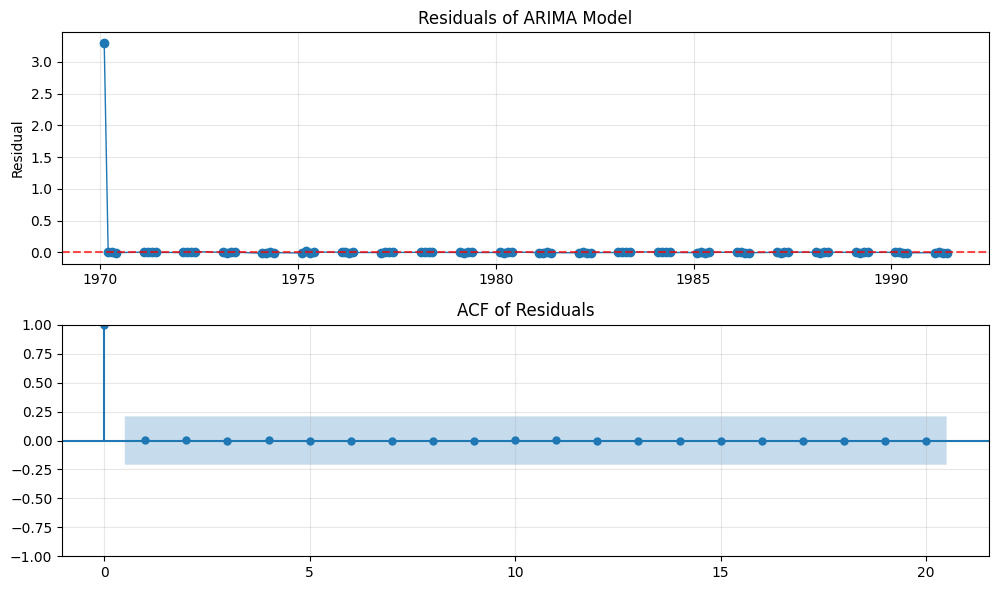


DIAGNOSTICS:
→ Residuals should look random (no pattern).
→ ACF: All bars inside blue band → good model.


In [8]:
# --------------------------------------------------------------
# 1. Read already-uploaded file
# --------------------------------------------------------------
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
import warnings
warnings.filterwarnings("ignore")

# Use the uploaded file
file_name = list(uploaded.keys())[0]
print(f"Using file: **{file_name}**\n")

df = pd.read_excel(io.BytesIO(uploaded[file_name]))
df.columns = df.columns.str.strip()

# Check available columns
print("Available columns:", df.columns.tolist())

# Extract YEAR and LOG PDI
if 'YEAR' not in df.columns or 'LOG PDI' not in df.columns:
    raise KeyError("Required columns 'YEAR' and 'LOG PDI' not found!")

data = df[['YEAR', 'LOG PDI']].dropna()
data = data.set_index('YEAR')
series = data['LOG PDI']

print(f"Time series length: {len(series)} observations\n")

# --------------------------------------------------------------
# 2. Grid search for best ARIMA(p,d,q)
# --------------------------------------------------------------
def find_best_arima(series, p_vals, d_vals, q_vals):
    best_aic = np.inf
    best_order = None
    best_model = None
    results_log = []

    print("Searching ARIMA models...\n")

    for p, d, q in product(p_vals, d_vals, q_vals):
        try:
            model = ARIMA(series, order=(p, d, q), trend='n')
            res = model.fit()
            results_log.append((p, d, q, res.aic))
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = (p, d, q)
                best_model = res
        except:
            continue

    # Show top 5 models
    results_log = sorted(results_log, key=lambda x: x[3])[:5]
    print("Top 5 models by AIC:")
    for p, d, q, aic in results_log:
        print(f"  ARIMA({p},{d},{q}) → AIC: {aic:.4f}")

    return best_order, best_model, best_aic

# Define search space
p_vals = range(0, 4)   # p = 0 to 3
d_vals = range(0, 3)   # d = 0 to 2
q_vals = range(0, 4)   # q = 0 to 3

best_order, best_model, best_aic = find_best_arima(series, p_vals, d_vals, q_vals)
p, d, q = best_order

# --------------------------------------------------------------
# 3. Print best model
# --------------------------------------------------------------
print("\n" + "="*60)
print("BEST ARIMA MODEL")
print("="*60)
print(f"Order: ARIMA({p}, {d}, {q})")
print(f"AIC: {best_aic:.4f}")
print("\nCoefficients:")
print(best_model.summary().tables[1])

# --------------------------------------------------------------
# 4. Interpretation
# --------------------------------------------------------------
print("\n" + "="*50)
print("INTERPRETATION")
print("="*50)

print(f"• p = {p} → {p} AR term(s)")
if p == 0:
    print("   → No dependence on past values.")
else:
    print(f"   → Current value depends on last {p} period(s).")

print(f"\n• d = {d} → {d} difference(s)")
if d == 0:
    print("   → Series is stationary in levels.")
elif d == 1:
    print("   → Series is I(1): non-stationary → first difference is stationary.")
elif d == 2:
    print("   → Series is I(2): second difference needed → check data.")

print(f"\n• q = {q} → {q} MA term(s)")
if q == 0:
    print("   → No dependence on past shocks.")
else:
    print(f"   → Current value depends on last {q} error(s).")

print(f"\nFinal Model: **ARIMA({p},{d},{q})**")
if d == 1:
    print(f"→ Equivalent to ARMA({p},{q}) on ΔLOG PDI")

# --------------------------------------------------------------
# 5. Diagnostics: Residuals + ACF
# --------------------------------------------------------------
residuals = best_model.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

# Residuals over time
ax1.plot(residuals.index, residuals, marker='o', linewidth=1)
ax1.axhline(0, color='red', linestyle='--', alpha=0.7)
ax1.set_title('Residuals of ARIMA Model')
ax1.set_ylabel('Residual')
ax1.grid(True, alpha=0.3)

# ACF of residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=min(20, len(residuals)//3), ax=ax2, alpha=0.05,
         title='ACF of Residuals')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDIAGNOSTICS:")
print("→ Residuals should look random (no pattern).")
print("→ ACF: All bars inside blue band → good model.")

Using file: **Table_21_1-2.xlsx**

Series length: 88 observations

Top 3 models:
  ARIMA(1,1,1) → AIC: -680.3262
  ARIMA(2,1,1) → AIC: -674.9547
  ARIMA(3,1,0) → AIC: -673.0353

BEST MODEL: ARIMA(1,1,1) | AIC: -680.3262

5-YEAR FORECAST (LOG PDI)
      Forecast  Lower 95%  Upper 95%
1992    3.5526     3.5435     3.5616
1993    3.5552     3.5423     3.5681
1994    3.5579     3.5419     3.5738
1995    3.5605     3.5420     3.5791
1996    3.5632     3.5423     3.5841

Forecast in ORIGINAL PDI (exp):
1992    34.90
1993    35.00
1994    35.09
1995    35.18
1996    35.28
Name: Forecast, dtype: float64

INTERPRETATION
--------------------------------------------------
• Best Model: ARIMA(1,1,1)
• d = 1 → LOG PDI is I(1): growth rate is stationary
• Forecast: expected LOG PDI over next 5 years
• exp(Forecast) = predicted PDI level



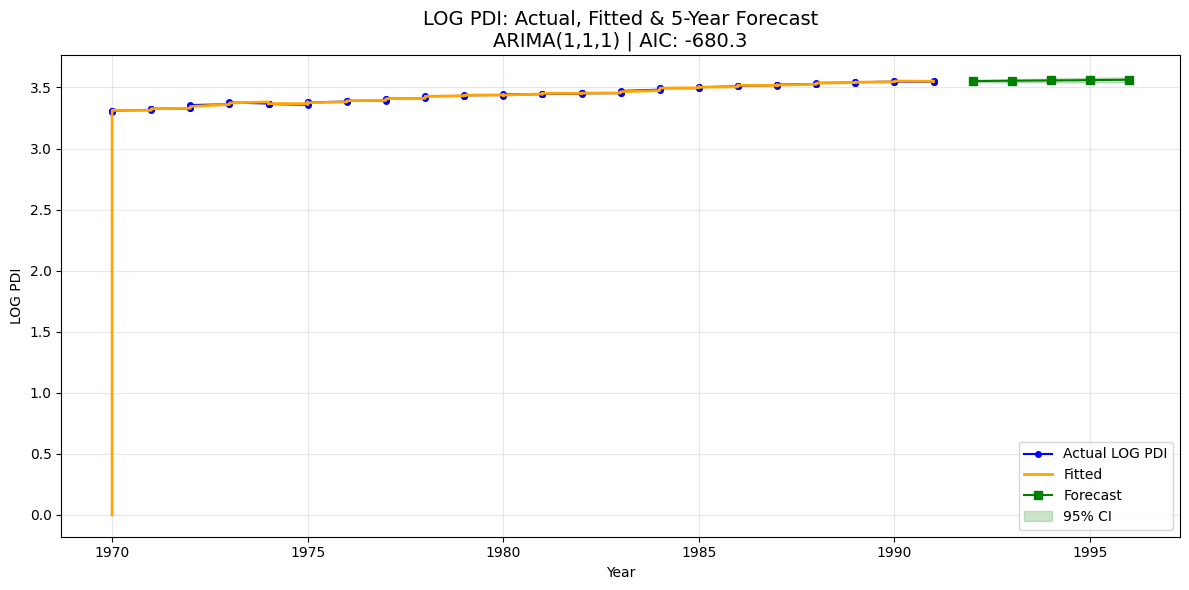

In [10]:
# --------------------------------------------------------------
# 1. Read file & prepare data (FIX: convert YEAR to int)
# --------------------------------------------------------------
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
import warnings
warnings.filterwarnings("ignore")

file_name = list(uploaded.keys())[0]
print(f"Using file: **{file_name}**\n")

df = pd.read_excel(io.BytesIO(uploaded[file_name]))
df.columns = df.columns.str.strip()

# === FIX: Convert YEAR to integer ===
df['YEAR'] = df['YEAR'].astype(int)

# Extract and clean
data = df[['YEAR', 'LOG PDI']].dropna()
data = data.set_index('YEAR')
series = data['LOG PDI']
print(f"Series length: {len(series)} observations\n")

# --------------------------------------------------------------
# 2. Grid search (same as before)
# --------------------------------------------------------------
def find_best_arima(series, p_vals, d_vals, q_vals):
    best_aic = np.inf
    best_order = None
    best_model = None
    log = []
    for p, d, q in product(p_vals, d_vals, q_vals):
        try:
            model = ARIMA(series, order=(p, d, q), trend='n')
            res = model.fit()
            log.append((p, d, q, res.aic))
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = (p, d, q)
                best_model = res
        except:
            continue
    log = sorted(log, key=lambda x: x[3])[:3]
    print("Top 3 models:")
    for p,d,q,aic in log:
        print(f"  ARIMA({p},{d},{q}) → AIC: {aic:.4f}")
    return best_order, best_model, best_aic

p_vals = range(0, 4)
d_vals = range(0, 3)
q_vals = range(0, 4)
best_order, best_model, best_aic = find_best_arima(series, p_vals, d_vals, q_vals)
p, d, q = best_order

print(f"\nBEST MODEL: ARIMA({p},{d},{q}) | AIC: {best_aic:.4f}\n")

# --------------------------------------------------------------
# 3. Forecast next 5 years
# --------------------------------------------------------------
forecast_steps = 5
forecast_result = best_model.get_forecast(steps=forecast_steps)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int(alpha=0.05)

# === FIX: Use integer years ===
last_year = data.index[-1]  # now int, e.g., 2023
future_years = pd.Index(range(last_year + 1, last_year + 1 + forecast_steps))

forecast_df = pd.DataFrame({
    'Forecast': forecast.values,
    'Lower 95%': conf_int.iloc[:, 0].values,
    'Upper 95%': conf_int.iloc[:, 1].values
}, index=future_years)

# --------------------------------------------------------------
# 4. Print forecast
# --------------------------------------------------------------
print("="*60)
print("5-YEAR FORECAST (LOG PDI)")
print("="*60)
print(forecast_df.round(4))
print()

# Convert to original PDI scale
print("Forecast in ORIGINAL PDI (exp):")
print(np.exp(forecast_df['Forecast']).round(2))
print()

# --------------------------------------------------------------
# 5. INTERPRETATION
# --------------------------------------------------------------
print("INTERPRETATION")
print("-" * 50)
print(f"• Best Model: ARIMA({p},{d},{q})")
print(f"• d = 1 → LOG PDI is I(1): growth rate is stationary")
print(f"• Forecast: expected LOG PDI over next 5 years")
print(f"• exp(Forecast) = predicted PDI level")
print()

# --------------------------------------------------------------
# 6. PLOT: Actual + Fitted + Forecast
# --------------------------------------------------------------
plt.figure(figsize=(12, 6))

# Actual
plt.plot(data.index, series, label='Actual LOG PDI', color='blue', marker='o', markersize=4)

# Fitted
fitted = best_model.fittedvalues
plt.plot(data.index, fitted, label='Fitted', color='orange', linewidth=2)

# Forecast
plt.plot(future_years, forecast, label='Forecast', color='green', marker='s', markersize=6)
plt.fill_between(future_years,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='green', alpha=0.2, label='95% CI')

plt.title(f'LOG PDI: Actual, Fitted & 5-Year Forecast\nARIMA({p},{d},{q}) | AIC: {best_aic:.1f}', fontsize=14)
plt.xlabel('Year')
plt.ylabel('LOG PDI')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()